In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
im_paths = [
    "data/sergem_robocar_20191202/robocar_recording_2019-12-02-17-26-13_6/frame_0000000169.jpg",
    "data/sergem_robocar_20191202/robocar_recording_2019-12-02-17-26-13_6/frame_0000000199.jpg",
    "data/sergem_robocar_20191202/robocar_recording_2019-12-02-17-27-13_7/frame_0000000053.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2016-02-11-17-27-20_f_1/frame_0000000131.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2017-11-27-17-59-38_9.fix/frame_0000000260.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2017-11-27-17-59-38_9.fix/frame_0000000379.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2017-11-27-18-43-52_13_f/frame_0000000154.jpg",
    "data/sergem_robocar_20191127/robocar_recording_20191127_w_bwd__2017-11-27-18-43-52_13_f/frame_0000000060.jpg",
    
]



In [3]:
def imread(path):
    img = cv2.imread(path)
    if img is None:
        raise IOError("Failed to open image '{}'".format(path))
    return img

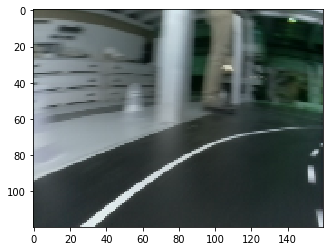

In [50]:
im = imread(im_paths[0])
im_r = cv2.resize(im, dsize=(160,120), interpolation=cv2.INTER_LINEAR)
plt.imshow(im_r)

In [305]:
lane_marking_max_size = 19

def kernel(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

def process(im, visualize=False, dbg_out=None):
    gray_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    small = cv2.resize(gray_image, dsize=(200,150), interpolation=cv2.INTER_LINEAR)
    small = gray_image
    small = small[small.shape[0] // 2:]

    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    cl1 = clahe.apply(small)
    q_low, q_high, q_th_lanes = np.percentile(cl1, [98, 99.9, 94,])

    edges = cv2.Canny(cl1, q_low, q_high)
    
    _, binary = cv2.threshold(cl1, q_th_lanes, 255, cv2.THRESH_BINARY)
    _, track = cv2.threshold(cl1, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    track_m = cv2.morphologyEx(track, cv2.MORPH_CLOSE, kernel(lane_marking_max_size))
                               
    edges_m = cv2.morphologyEx(edges, cv2.MORPH_DILATE, kernel(lane_marking_max_size // 2))
    confirmed = edges_m * binary * (track_m)
    if visualize:
        print(q_low, q_high)
        plt.figure()
        plt.imshow(edges_m)
        plt.figure()
        plt.imshow(cl1, cmap='gray')
        plt.figure()
        plt.imshow(small, cmap='gray')
        plt.figure()
        plt.imshow(binary, cmap='gray')
        
        plt.figure()
        plt.imshow(track, cmap='gray')
        plt.figure()
        plt.imshow(track_m, cmap='gray')
    
        plt.figure()
        plt.imshow(confirmed, cmap='gray')
        
    
    if dbg_out is not None:
        dbg_out.update({'edges': edges, 
                        'small': small, 
                        'cl1':cl1, 
                        'binary': binary,
                        'track': track,
                        'track_m': track_m,
                       'confirmed': confirmed,
                       
                       })
        
        
    return confirmed 



In [306]:
# %timeit process(im, visualize=0)

129.0 177.0


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

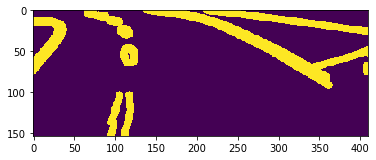

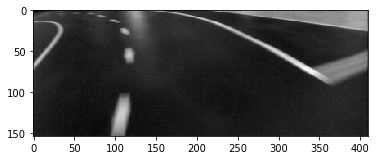

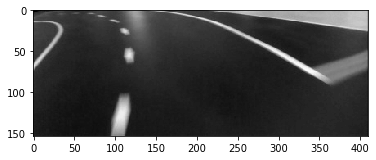

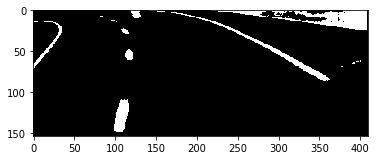

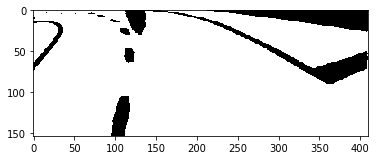

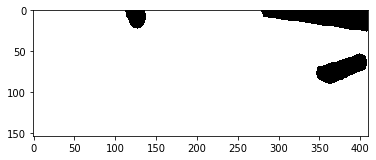

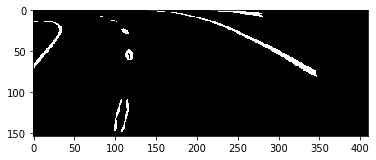

In [303]:
im = imread(im_paths[1])
process(im, visualize=1, dbg_out=dbg)

In [271]:
# track = dbg['track']

# plt.figure()
# plt.imshow(m)

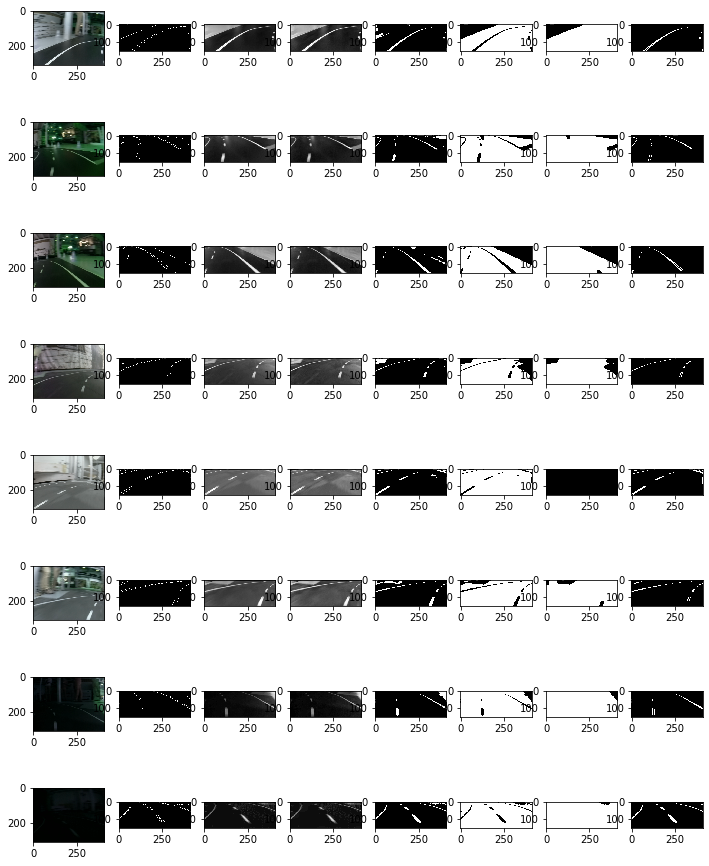

In [304]:

ax = None
for i, path in enumerate(im_paths):
    im = imread(path)
    
    dbg = {}
    res = process(im, dbg_out=dbg)
    if ax is None:
        f, ax = plt.subplots(len(im_paths), len(dbg)+1, figsize=(12,16))
    ax[i][0].imshow(im)
    for j, (k, v) in enumerate(dbg.items()):
        ax[i][j+1].imshow(v, cmap='gray')
    

In [307]:
binary = dbg['binary']
confirmed = dbg['confirmed']


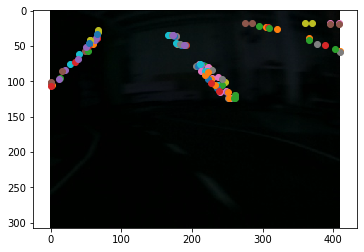

In [344]:
hough_threshold = 20
hough_min_line_length = lane_marking_max_size / 2
hough_max_line_gap = 1
lines = cv2.HoughLinesP(confirmed, 1, np.pi / 180, hough_threshold,  
                        minLineLength=hough_min_line_length, maxLineGap=hough_max_line_gap)
if lines is not None:
    lines = np.array(lines[:, 0])
else:
    lines = []
lines

plt.imshow(im)
for line in lines:
    plt.scatter(line[0::2], line[1::2])

In [126]:
308/410, 120/160

(0.751219512195122, 0.75)